In [2]:
from numpy import *
from matplotlib.pylab import *
import random
import sys
import io
import os
import glob
import h5py

import IPython

#from pydub import AudioSegment
#from td_utils import *

In [3]:
!jupyter kernelspec list

Available kernels:
  deepl      /export/home1/users/bssn/serna/.local/share/jupyter/kernels/deepl
  python3    /export/home1/users/bssn/serna/.local/share/jupyter/kernels/python3


In [4]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12519660797258083788
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7907914548
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5534241471716872602
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:05:00.0, compute capability: 6.1"
]


In [183]:
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D, Concatenate
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam
from keras.regularizers import L1L2
from keras import backend as K
from keras.layers import MaxPooling2D, AveragePooling2D,Conv2D
from keras.layers import Lambda
from keras.backend import transpose
from keras import regularizers

In [184]:
Tx,size = Ft.shape
#nfreq = 101

In [9]:
def get_random_time_segment(segment_frames,total_frames=12000):
    '''
    Gets a random time segment of duration segment_frames in a file
    with number of frames: total_frames
    '''
    
    segment_start = randint(0, high = total_frames-
                                   segment_frames)
    segment_end = segment_start + segment_frames
    
    return (segment_start, segment_end)

## Loading data set.

This is a big dataset, so we are going to divide it in 4000 samples for  training set and 100 dev_set and 100 test_set.

In [13]:
pars = load("Training/roival.npy")
print(len(pars),pars)

1015 [0 0 0 ... 0 0 0]


It is not a NR


<Figure size 432x288 with 0 Axes>

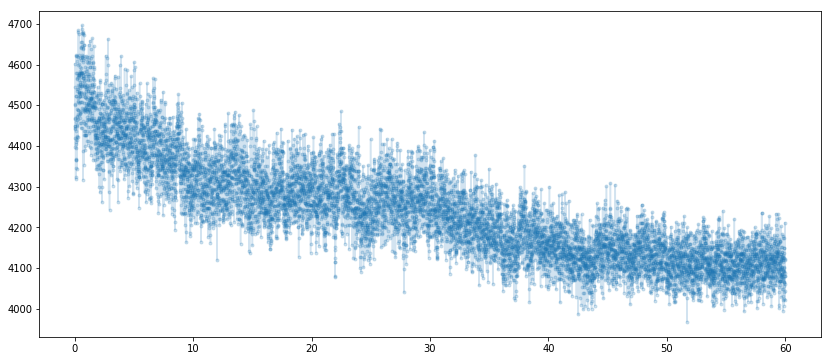

<Figure size 432x288 with 0 Axes>

In [75]:
i = randint(0,len(pars))
Ft = load("Training/roi"+str(i).zfill(4)+".npy")
t = arange(Ft.shape[0])*5e-3
if pars[i] == 0:
    print("It is not a NR")
else:
    print("It is a NR")
    
figure(figsize= (14,6))
plot(t,sum(Ft,axis=1),'.-',alpha=0.2)
figure()

In [682]:
# 1 segundo. This will be used as another (meta)parameter, 
# which we want to decrease
nframes = 1000 
pars = load("Training/roival.npy")

lpar = len(pars)

X = []
Y = []
for i in permutation(lpar-200):
    xt = load("Training/roi"+str(i).zfill(4)+".npy")
    par = pars[i]
    nj = 3
    if par == 1: nj = 8
    for j in range(nj):
        start,end = get_random_time_segment(nframes)
        xtt = xt[start:end,:].transpose()
        s0 = std(xtt)/mean(xtt)
        s1 = mean(xtt)
        xtt = xtt/s1
        s2 = std(xtt)
        s3 = mean((xtt-1.0)**3)/s2**3
        s4 = mean((xtt-1.0)**4)/s2**4
        s0t = array([s2,s3,s4,(s3**2+1/s4),0,0,0,0,0])
        
        xtt = column_stack((s0t,xtt))
        X.append(xtt)
        #Y.append(concatenate((yt[start:end],par[-1:])))
        Y.append(par)
X = array(X)
Y = array(Y)
print(X.shape, Y.shape)
    

Xdev = []
Ydev = []
for i in range(lpar-200,lpar):
    xt = load("Training/roi"+str(i).zfill(4)+".npy")
    par = pars[i]
    for j in range(5):
        start,end = get_random_time_segment(nframes)
        xtt = xt[start:end,:].transpose()
        s0 = std(xtt)/mean(xtt)
        s1 = mean(xtt)
        xtt = xtt/s1
        s2 = std(xtt)
        s3 = mean((xtt-1.0)**3)/s2**3
        s4 = mean((xtt-1.0)**4)/s2**4
        s0t = array([s2,s3,s4,(s3**2+1/s4),0,0,0,0,0])
        
        xtt = column_stack((s0t,xtt))
        Xdev.append(xtt)
        #Ydev.append(concatenate((yt[start:end],par[-1:])))
        Ydev.append(par)
Xdev = array(Xdev)
Ydev = array(Ydev)

print(Xdev.shape, Ydev.shape)


'''
Xdev = array(X).transpose()
Ydev = array(Y).transpose()
for i in range(4000,4100):
    xt = load("syndat/d"+str(i).zfill(4)+".npy")
    yt = load("syndat/r"+str(i).zfill(4)+".npy")
    for j in range(20):
        start,end = get_random_time_segment(nframes)
        Xdev.append(xt[start:end])
        Ydev.append(yt[start:end])
'''        
        

(3465, 9, 1001) (3465,)
(1000, 9, 1001) (1000,)


'\nXdev = array(X).transpose()\nYdev = array(Y).transpose()\nfor i in range(4000,4100):\n    xt = load("syndat/d"+str(i).zfill(4)+".npy")\n    yt = load("syndat/r"+str(i).zfill(4)+".npy")\n    for j in range(20):\n        start,end = get_random_time_segment(nframes)\n        Xdev.append(xt[start:end])\n        Ydev.append(yt[start:end])\n'

In [530]:
#xtt = xt[start:end,:].transpose()
#s0 = std(xtt)/mean(xtt)
#s1 = mean(xtt)
#xtt = xtt/s1
#s2 = std(xtt)
#s3 = mean((xtt-1.0)**3)/s2**3
#s4 = mean((xtt-1.0)**4)/s2**4

#s0t = array([s2,s3,s4,(s3**2+1/s4),0,0,0,0,0])
#print(s1,s2,s3,s4,(s3**2+1)/s4)
#column_stack((s0t,xtt)).shape

It is a NR


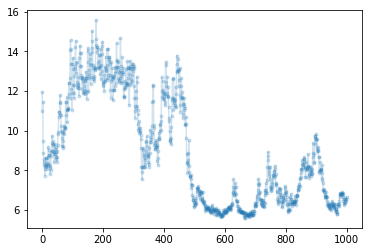

In [531]:
colors = array(['C0','C1'])
t = arange(nframes)
# We plot some random pieces we chose to fit the network!

i = randint(0,X.shape[0])

if Y[i] == 0:
    print("It is not a NR")
else:
    print("It is a NR")

plot(t,sum(X[i,:,1:],axis=0),'.-',alpha=0.2)


In [532]:
X.shape

(3465, 9, 1001)

In [535]:
sum(Y==1)

1632

## Definition of the network

Here, we define the neural network. We may start with just nframes logistic regressions?!

In [683]:
X = reshape(X,(X.shape[0],X.shape[1],X.shape[2],1))
Y = reshape(Y,(Y.shape[0],1,1,1))

Xdev = reshape(Xdev,(Xdev.shape[0],Xdev.shape[1],Xdev.shape[2],1))
Ydev = reshape(Ydev,(Ydev.shape[0],1,1,1))

print(X.shape,Y.shape)

(3465, 9, 1001, 1) (3465, 1, 1, 1)


In [672]:
def model(input_shape):
    '''
    Function used to create the model's graph in Keras
    
    Argument:
    -- input_shape. Shape of the model's input data (Keras conventions?!)
    
    Returns:
    -- model. Keras model instance
    '''
    tf_session = K.get_session()
    
    X_input = Input(shape = input_shape)
    
    # Layers

    X = X_input
    
    Xa = Lambda(lambda x: x[:,:,1:,:], output_shape=(input_shape[0],input_shape[1]-1,input_shape[2]))(X)
    X  = Lambda(lambda x: x[:,:4,:1,:], output_shape=(4,1,1))(X)
    X = Reshape((1,1,4))(X)
 
    Xashape = array(input_shape)
    Xashape[-1] -= 1 
    n1, n2, s = (20,10,4)

    Xa = Dropout(0.2)(Xa)
    Xb = Conv2D(20,(9,40),strides=(1,5),padding="valid")(Xa)
    Xc = AveragePooling2D((9,40),strides=(1,5),padding="valid")(Xa)
    Xa = MaxPooling2D((9,40),strides=(1,5),padding="valid")(Xa)
    
    Xa = Concatenate()([Xa,Xb,Xc])
    Xa = BatchNormalization()(Xa)   

    Xa = Reshape((1,1,193*22))(Xa)
    
    Xa = Dropout(0.2)(Xa)
    Xa = Dense(4,activation="sigmoid")(Xa)
    #Xa = BatchNormalization()(Xa)
        

    X = Concatenate(axis=3)([X,Xa])
    X = Dense(1,activation="sigmoid")(X)

    #X = Xa
    # Defining the model
    
    model = Model(inputs = X_input, outputs = X)
    
    return model

In [673]:
model = model(input_shape = (9,1+nframes,1))

In [674]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_87 (InputLayer)           (None, 9, 1001, 1)   0                                            
__________________________________________________________________________________________________
lambda_107 (Lambda)             (None, 9, 1000, 1)   0           input_87[0][0]                   
__________________________________________________________________________________________________
dropout_94 (Dropout)            (None, 9, 1000, 1)   0           lambda_107[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_69 (MaxPooling2D) (None, 1, 193, 1)    0           dropout_94[0][0]                 
__________________________________________________________________________________________________
conv2d_75 

### Fit the model!

In [675]:
from keras.optimizers import SGD

In [680]:
opt = Adam(lr=0.001, beta_1=0.95, beta_2=0.999, decay=0.001)
#opt = SGD(lr=100, decay=1e-6, momentum=1.9)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])


In [677]:
Wsave = model.get_weights()
#model.set_weights(Wsave)

In [666]:
Y.shape

(3003, 1, 1, 1)

In [687]:
history3 = model.fit(X, Y, batch_size = 500, epochs =1000)

Epoch 1/1000
3465/3465 [==============================] - 0s 106us/step - loss: 0.4679 - acc: 0.7792
Epoch 2/1000
3465/3465 [==============================] - 0s 94us/step - loss: 0.4744 - acc: 0.7755
Epoch 3/1000
3465/3465 [==============================] - 0s 93us/step - loss: 0.4723 - acc: 0.7789
Epoch 4/1000
3465/3465 [==============================] - 0s 94us/step - loss: 0.4701 - acc: 0.7763
Epoch 5/1000
3465/3465 [==============================] - 0s 91us/step - loss: 0.4745 - acc: 0.7743
Epoch 6/1000
3465/3465 [==============================] - 0s 92us/step - loss: 0.4733 - acc: 0.7760
Epoch 7/1000
3465/3465 [==============================] - 0s 89us/step - loss: 0.4710 - acc: 0.7760
Epoch 8/1000
3465/3465 [==============================] - 0s 94us/step - loss: 0.4737 - acc: 0.7743
Epoch 9/1000
3465/3465 [==============================] - 0s 90us/step - loss: 0.4732 - acc: 0.7795
Epoch 10/1000
3465/3465 [==============================] - 0s 92us/step - loss: 0.4735 - acc: 0.776

3465/3465 [==============================] - 0s 96us/step - loss: 0.4559 - acc: 0.7882
Epoch 163/1000
3465/3465 [==============================] - 0s 94us/step - loss: 0.4562 - acc: 0.7847
Epoch 164/1000
3465/3465 [==============================] - 0s 95us/step - loss: 0.4551 - acc: 0.7893
Epoch 165/1000
3465/3465 [==============================] - 0s 94us/step - loss: 0.4578 - acc: 0.7916
Epoch 166/1000
3465/3465 [==============================] - 0s 96us/step - loss: 0.4555 - acc: 0.7902
Epoch 167/1000
3465/3465 [==============================] - 0s 96us/step - loss: 0.4554 - acc: 0.7902
Epoch 168/1000
3465/3465 [==============================] - 0s 96us/step - loss: 0.4577 - acc: 0.7885
Epoch 169/1000
3465/3465 [==============================] - 0s 94us/step - loss: 0.4560 - acc: 0.7879
Epoch 170/1000
3465/3465 [==============================] - 0s 94us/step - loss: 0.4557 - acc: 0.7890
Epoch 171/1000
3465/3465 [==============================] - 0s 98us/step - loss: 0.4576 - acc: 0.

3465/3465 [==============================] - 0s 94us/step - loss: 0.4495 - acc: 0.7942
Epoch 323/1000
3465/3465 [==============================] - 0s 96us/step - loss: 0.4484 - acc: 0.7983
Epoch 324/1000
3465/3465 [==============================] - 0s 95us/step - loss: 0.4509 - acc: 0.7957
Epoch 325/1000
3465/3465 [==============================] - 0s 93us/step - loss: 0.4490 - acc: 0.7934
Epoch 326/1000
3465/3465 [==============================] - 0s 93us/step - loss: 0.4500 - acc: 0.7960
Epoch 327/1000
3465/3465 [==============================] - 0s 93us/step - loss: 0.4497 - acc: 0.7942
Epoch 328/1000
3465/3465 [==============================] - 0s 93us/step - loss: 0.4483 - acc: 0.7951
Epoch 329/1000
3465/3465 [==============================] - 0s 96us/step - loss: 0.4506 - acc: 0.7948
Epoch 330/1000
3465/3465 [==============================] - 0s 93us/step - loss: 0.4469 - acc: 0.7974
Epoch 331/1000
3465/3465 [==============================] - 0s 94us/step - loss: 0.4465 - acc: 0.

3465/3465 [==============================] - 0s 94us/step - loss: 0.4426 - acc: 0.7974
Epoch 483/1000
3465/3465 [==============================] - 0s 92us/step - loss: 0.4427 - acc: 0.7986
Epoch 484/1000
3465/3465 [==============================] - 0s 95us/step - loss: 0.4445 - acc: 0.8000
Epoch 485/1000
3465/3465 [==============================] - 0s 95us/step - loss: 0.4400 - acc: 0.8032
Epoch 486/1000
3465/3465 [==============================] - 0s 95us/step - loss: 0.4450 - acc: 0.7954
Epoch 487/1000
3465/3465 [==============================] - 0s 98us/step - loss: 0.4414 - acc: 0.8020
Epoch 488/1000
3465/3465 [==============================] - 0s 95us/step - loss: 0.4408 - acc: 0.8000
Epoch 489/1000
3465/3465 [==============================] - 0s 93us/step - loss: 0.4414 - acc: 0.8009
Epoch 490/1000
3465/3465 [==============================] - 0s 93us/step - loss: 0.4432 - acc: 0.7994
Epoch 491/1000
3465/3465 [==============================] - 0s 92us/step - loss: 0.4392 - acc: 0.

3465/3465 [==============================] - 0s 94us/step - loss: 0.4363 - acc: 0.8049
Epoch 643/1000
3465/3465 [==============================] - 0s 94us/step - loss: 0.4356 - acc: 0.8023
Epoch 644/1000
3465/3465 [==============================] - 0s 96us/step - loss: 0.4345 - acc: 0.8049
Epoch 645/1000
3465/3465 [==============================] - 0s 97us/step - loss: 0.4388 - acc: 0.7997
Epoch 646/1000
3465/3465 [==============================] - 0s 93us/step - loss: 0.4364 - acc: 0.8049
Epoch 647/1000
3465/3465 [==============================] - 0s 93us/step - loss: 0.4358 - acc: 0.8040
Epoch 648/1000
3465/3465 [==============================] - 0s 93us/step - loss: 0.4370 - acc: 0.8063
Epoch 649/1000
3465/3465 [==============================] - 0s 97us/step - loss: 0.4371 - acc: 0.8038
Epoch 650/1000
3465/3465 [==============================] - 0s 92us/step - loss: 0.4336 - acc: 0.8072
Epoch 651/1000
3465/3465 [==============================] - 0s 92us/step - loss: 0.4394 - acc: 0.

3465/3465 [==============================] - 0s 93us/step - loss: 0.4303 - acc: 0.8115
Epoch 803/1000
3465/3465 [==============================] - 0s 95us/step - loss: 0.4329 - acc: 0.8075
Epoch 804/1000
3465/3465 [==============================] - 0s 94us/step - loss: 0.4342 - acc: 0.8078
Epoch 805/1000
3465/3465 [==============================] - 0s 94us/step - loss: 0.4320 - acc: 0.8081
Epoch 806/1000
3465/3465 [==============================] - 0s 95us/step - loss: 0.4351 - acc: 0.8017
Epoch 807/1000
3465/3465 [==============================] - 0s 96us/step - loss: 0.4292 - acc: 0.8104
Epoch 808/1000
3465/3465 [==============================] - 0s 96us/step - loss: 0.4308 - acc: 0.8075
Epoch 809/1000
3465/3465 [==============================] - 0s 94us/step - loss: 0.4294 - acc: 0.8078
Epoch 810/1000
3465/3465 [==============================] - 0s 94us/step - loss: 0.4326 - acc: 0.8081
Epoch 811/1000
3465/3465 [==============================] - 0s 91us/step - loss: 0.4320 - acc: 0.

3465/3465 [==============================] - 0s 95us/step - loss: 0.4310 - acc: 0.8089
Epoch 963/1000
3465/3465 [==============================] - 0s 93us/step - loss: 0.4259 - acc: 0.8133
Epoch 964/1000
3465/3465 [==============================] - 0s 94us/step - loss: 0.4243 - acc: 0.8141
Epoch 965/1000
3465/3465 [==============================] - 0s 94us/step - loss: 0.4288 - acc: 0.8118
Epoch 966/1000
3465/3465 [==============================] - 0s 95us/step - loss: 0.4258 - acc: 0.8124
Epoch 967/1000
3465/3465 [==============================] - 0s 92us/step - loss: 0.4298 - acc: 0.8075
Epoch 968/1000
3465/3465 [==============================] - 0s 95us/step - loss: 0.4291 - acc: 0.8081
Epoch 969/1000
3465/3465 [==============================] - 0s 94us/step - loss: 0.4287 - acc: 0.8127
Epoch 970/1000
3465/3465 [==============================] - 0s 92us/step - loss: 0.4269 - acc: 0.8153
Epoch 971/1000
3465/3465 [==============================] - 0s 93us/step - loss: 0.4272 - acc: 0.

In [638]:
Wsave_trained1 = model.get_weights()
#Wsave_trained2 = model.get_weights()
#Wsave_trained3 = model.get_weights()

dict_keys(['loss', 'acc'])


Text(0.5,0,'epoch')

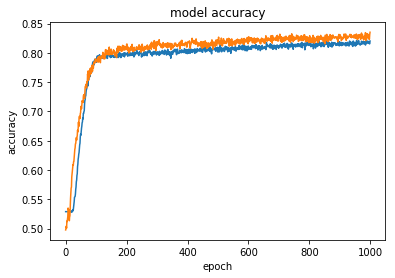

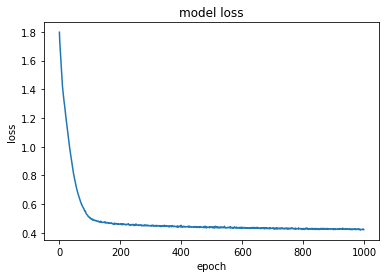

In [686]:
figure()
print(history3.history.keys())
#plot(history.history['acc'])
plot(history3.history['acc'])
plot(history4.history['acc'])

title('model accuracy')
ylabel('accuracy')
xlabel('epoch')
figure()
#plot(history.history['loss'])
plot(history3.history['loss'])

title('model loss')
ylabel('loss')
xlabel('epoch')


In [688]:
loss, acc = model.evaluate(Xdev, Ydev)
print("Dev set accuracy = ", acc)

1000/1000 [==============================] - 1s 1ms/step
Dev set accuracy =  0.873


In [658]:
nframes = 1000 

pars = load("/export/home1/users/bssn/serna/Downloads/Classifier/fullimage/moviefull/roival.npy")
pars = pars[:,2]
lpar = len(pars)

X = []
Y = []
for i in permutation(lpar-200):
    xt = load("/export/home1/users/bssn/serna/Downloads/Classifier/fullimage/moviefull/roi_F01A"+str(i).zfill(4)+".npy")
    par = pars[i]
    nj = 3
    if par == 1: nj = 3
    for j in range(nj):
        start,end = get_random_time_segment(nframes)
        xtt = xt[start:end,:].transpose()
        s0 = std(xtt)/mean(xtt)
        s1 = mean(xtt)
        xtt = xtt/s1
        s2 = std(xtt)
        s3 = mean((xtt-1.0)**3)/s2**3
        s4 = mean((xtt-1.0)**4)/s2**4
        s0t = array([s2,s3,s4,(s3**2+1/s4),0,0,0,0,0])
        
        xtt = column_stack((s0t,xtt))
        X.append(xtt)
        #Y.append(concatenate((yt[start:end],par[-1:])))
        Y.append(par)
X = array(X)
Y = array(Y)
print(X.shape, Y.shape)
    


(3003, 9, 1001) (3003,)


In [678]:
X = reshape(X,(X.shape[0],X.shape[1],X.shape[2],1))
Y = reshape(Y,(Y.shape[0],1,1,1))

In [681]:
history4 = model.fit(X, Y, batch_size = 500, epochs =1000)

Epoch 1/1000
3003/3003 [==============================] - 3s 1ms/step - loss: 1.8918 - acc: 0.4978
Epoch 2/1000
3003/3003 [==============================] - 0s 81us/step - loss: 1.8495 - acc: 0.4998
Epoch 3/1000
3003/3003 [==============================] - 0s 81us/step - loss: 1.8151 - acc: 0.5042
Epoch 4/1000
3003/3003 [==============================] - 0s 83us/step - loss: 1.7734 - acc: 0.5008
Epoch 5/1000
3003/3003 [==============================] - 0s 82us/step - loss: 1.7492 - acc: 0.5128
Epoch 6/1000
3003/3003 [==============================] - 0s 81us/step - loss: 1.7199 - acc: 0.5122
Epoch 7/1000
3003/3003 [==============================] - 0s 81us/step - loss: 1.6973 - acc: 0.5165
Epoch 8/1000
3003/3003 [==============================] - 0s 81us/step - loss: 1.6550 - acc: 0.5205
Epoch 9/1000
3003/3003 [==============================] - 0s 80us/step - loss: 1.6317 - acc: 0.5351
Epoch 10/1000
3003/3003 [==============================] - 0s 81us/step - loss: 1.6012 - acc: 0.5321


3003/3003 [==============================] - 0s 84us/step - loss: 0.4852 - acc: 0.7949
Epoch 163/1000
3003/3003 [==============================] - 0s 82us/step - loss: 0.4840 - acc: 0.7979
Epoch 164/1000
3003/3003 [==============================] - 0s 82us/step - loss: 0.4894 - acc: 0.7975
Epoch 165/1000
3003/3003 [==============================] - 0s 81us/step - loss: 0.4803 - acc: 0.8009
Epoch 166/1000
3003/3003 [==============================] - 0s 81us/step - loss: 0.4767 - acc: 0.7989
Epoch 167/1000
3003/3003 [==============================] - 0s 84us/step - loss: 0.4818 - acc: 0.7982
Epoch 168/1000
3003/3003 [==============================] - 0s 83us/step - loss: 0.4800 - acc: 0.7919
Epoch 169/1000
3003/3003 [==============================] - 0s 80us/step - loss: 0.4737 - acc: 0.8035
Epoch 170/1000
3003/3003 [==============================] - 0s 83us/step - loss: 0.4682 - acc: 0.8082
Epoch 171/1000
3003/3003 [==============================] - 0s 82us/step - loss: 0.4730 - acc: 0.

3003/3003 [==============================] - 0s 81us/step - loss: 0.4363 - acc: 0.8095
Epoch 323/1000
3003/3003 [==============================] - 0s 81us/step - loss: 0.4352 - acc: 0.8129
Epoch 324/1000
3003/3003 [==============================] - 0s 82us/step - loss: 0.4363 - acc: 0.8125
Epoch 325/1000
3003/3003 [==============================] - 0s 84us/step - loss: 0.4357 - acc: 0.8122
Epoch 326/1000
3003/3003 [==============================] - 0s 82us/step - loss: 0.4342 - acc: 0.8152
Epoch 327/1000
3003/3003 [==============================] - 0s 82us/step - loss: 0.4331 - acc: 0.8139
Epoch 328/1000
3003/3003 [==============================] - 0s 82us/step - loss: 0.4352 - acc: 0.8139
Epoch 329/1000
3003/3003 [==============================] - 0s 81us/step - loss: 0.4311 - acc: 0.8159
Epoch 330/1000
3003/3003 [==============================] - 0s 84us/step - loss: 0.4304 - acc: 0.8129
Epoch 331/1000
3003/3003 [==============================] - 0s 87us/step - loss: 0.4369 - acc: 0.

3003/3003 [==============================] - 0s 81us/step - loss: 0.4262 - acc: 0.8115
Epoch 483/1000
3003/3003 [==============================] - 0s 82us/step - loss: 0.4250 - acc: 0.8132
Epoch 484/1000
3003/3003 [==============================] - 0s 81us/step - loss: 0.4224 - acc: 0.8135
Epoch 485/1000
3003/3003 [==============================] - 0s 83us/step - loss: 0.4303 - acc: 0.8062
Epoch 486/1000
3003/3003 [==============================] - 0s 83us/step - loss: 0.4248 - acc: 0.8185
Epoch 487/1000
3003/3003 [==============================] - 0s 83us/step - loss: 0.4209 - acc: 0.8175
Epoch 488/1000
3003/3003 [==============================] - 0s 91us/step - loss: 0.4253 - acc: 0.8132
Epoch 489/1000
3003/3003 [==============================] - 0s 83us/step - loss: 0.4280 - acc: 0.8149
Epoch 490/1000
3003/3003 [==============================] - 0s 84us/step - loss: 0.4214 - acc: 0.8172
Epoch 491/1000
3003/3003 [==============================] - 0s 81us/step - loss: 0.4212 - acc: 0.

3003/3003 [==============================] - 0s 86us/step - loss: 0.4149 - acc: 0.8232
Epoch 643/1000
3003/3003 [==============================] - 0s 85us/step - loss: 0.4175 - acc: 0.8205
Epoch 644/1000
3003/3003 [==============================] - 0s 82us/step - loss: 0.4135 - acc: 0.8252
Epoch 645/1000
3003/3003 [==============================] - 0s 93us/step - loss: 0.4160 - acc: 0.8242
Epoch 646/1000
3003/3003 [==============================] - 0s 85us/step - loss: 0.4190 - acc: 0.8228
Epoch 647/1000
3003/3003 [==============================] - 0s 95us/step - loss: 0.4171 - acc: 0.8192
Epoch 648/1000
3003/3003 [==============================] - 0s 83us/step - loss: 0.4135 - acc: 0.8242
Epoch 649/1000
3003/3003 [==============================] - 0s 81us/step - loss: 0.4149 - acc: 0.8232
Epoch 650/1000
3003/3003 [==============================] - 0s 82us/step - loss: 0.4174 - acc: 0.8208
Epoch 651/1000
3003/3003 [==============================] - 0s 79us/step - loss: 0.4199 - acc: 0.

3003/3003 [==============================] - 0s 85us/step - loss: 0.4079 - acc: 0.8292
Epoch 803/1000
3003/3003 [==============================] - 0s 83us/step - loss: 0.4114 - acc: 0.8225
Epoch 804/1000
3003/3003 [==============================] - 0s 82us/step - loss: 0.4137 - acc: 0.8205
Epoch 805/1000
3003/3003 [==============================] - 0s 80us/step - loss: 0.4123 - acc: 0.8178
Epoch 806/1000
3003/3003 [==============================] - 0s 81us/step - loss: 0.4141 - acc: 0.8218
Epoch 807/1000
3003/3003 [==============================] - 0s 80us/step - loss: 0.4117 - acc: 0.8255
Epoch 808/1000
3003/3003 [==============================] - 0s 80us/step - loss: 0.4088 - acc: 0.8245
Epoch 809/1000
3003/3003 [==============================] - 0s 82us/step - loss: 0.4158 - acc: 0.8178
Epoch 810/1000
3003/3003 [==============================] - 0s 82us/step - loss: 0.4118 - acc: 0.8238
Epoch 811/1000
3003/3003 [==============================] - 0s 78us/step - loss: 0.4111 - acc: 0.

3003/3003 [==============================] - 0s 82us/step - loss: 0.4106 - acc: 0.8252
Epoch 963/1000
3003/3003 [==============================] - 0s 81us/step - loss: 0.4023 - acc: 0.8302
Epoch 964/1000
3003/3003 [==============================] - 0s 81us/step - loss: 0.4083 - acc: 0.8262
Epoch 965/1000
3003/3003 [==============================] - 0s 81us/step - loss: 0.4018 - acc: 0.8308
Epoch 966/1000
3003/3003 [==============================] - 0s 84us/step - loss: 0.4037 - acc: 0.8298
Epoch 967/1000
3003/3003 [==============================] - 0s 82us/step - loss: 0.4060 - acc: 0.8312
Epoch 968/1000
3003/3003 [==============================] - 0s 82us/step - loss: 0.4051 - acc: 0.8308
Epoch 969/1000
3003/3003 [==============================] - 0s 83us/step - loss: 0.4104 - acc: 0.8228
Epoch 970/1000
3003/3003 [==============================] - 0s 83us/step - loss: 0.4068 - acc: 0.8302
Epoch 971/1000
3003/3003 [==============================] - 0s 83us/step - loss: 0.4082 - acc: 0.

In [685]:
Wsave_trained2 = model.get_weights()

It is not a NR
Prediction is OK
It is not a NR
Prediction is OK
It is not a NR
Prediction is OK
It is not a NR
Prediction is OK
It is not a NR
Prediction is OK
It is a NR
Prediction is OK
It is a NR
Prediction is OK
It is a NR
Prediction is OK
It is a NR
Prediction is OK
It is a NR
Prediction is OK
It is not a NR
Prediction is OK
It is not a NR
Prediction is OK
It is not a NR
Prediction is OK
It is not a NR
Prediction is OK
It is not a NR
Prediction is OK
It is not a NR
Prediction is OK
It is not a NR
Prediction is OK
It is not a NR
Prediction is OK
It is not a NR
Prediction is OK
It is not a NR
Prediction is OK
It is a NR
Prediction is OK
It is a NR
Prediction is OK
It is a NR
Prediction is OK
It is a NR
Prediction is OK
It is a NR
Prediction is OK
It is a NR
Prediction is OK
It is a NR
Prediction is OK
It is a NR
Prediction is OK
It is a NR
Prediction is OK
It is a NR
Prediction is OK
It is not a NR
Prediction is OK
It is not a NR
Prediction is OK
It is not a NR
Prediction is OK
It i

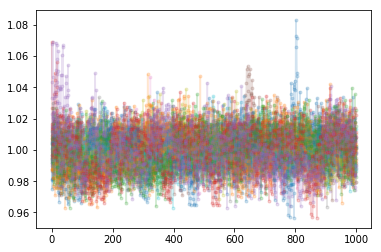

In [609]:
colors = array(['C0','C1'])
t = arange(nframes)
# We plot some random pieces we chose to fit the network!

it = array([0,0])
it0 = array([0,0])
for j in range(200):
    i = randint(0,Xdev.shape[0])
    i = j

    y = model.predict(reshape(Xdev[i,:,:],(1,9,1001,1)))

    if Ydev[i] == 0:
        it0[0] += 1

        print("It is not a NR")
        if y < 0.5:
            print("Prediction is OK")
        else:
            print("Prediction missed it")
            it[0] += 1

            #plot(t,mean(Xdev[i,:,1:],axis=0),'.-',alpha=0.2)
            #show()
            #break
            #k = input("..")
    else:
        it0[1] += 1
        print("It is a NR")
        if y > 0.5 :
            print("Prediction is OK")
            
        else:
            print("Prediction missed it")
            it[1] += 1
            plot(t,mean(Xdev[i,:,1:],axis=0),'.-',alpha=0.2)
            #show()
            #break
    
    

#plot(t,mean(Xdev[i,:,1:],axis=0),'.-',alpha=0.2)

In [689]:
model.save("classifier20181120_B.h5")


In [607]:
sum(pars==1)


258

In [608]:
len(pars[:])

1015

In [613]:
wfinal = model.weights[-1]